# 第9章 现代循环神经网络

## 9.1 门控循环单元（GRU） 

### 练习 9.1.1

假设我们只想使用时间步 $t'$ 的输入来预测时间步 $t > t'$ 的输出。对于每个时间步，重置门和更新门的最佳值是什么？

**解答：**

&emsp;&emsp;如果只想采用时间步 $t'$ 的输出来预测时间步 $t$ 的输出，则意味着模型需要减少之前时间步在计算中做出的贡献，根据候选隐状态计算公式 9.1.2：  
$$\tilde{H}_t = \tanh(X_tW_{xh}+(R_t \odot H_{t-1})W_{hh}+b_r)$$
因此需要令**重置门的值趋向于0**，减少过去状态的影响，令模型只考虑当前时间步 $t'$ 所做出的贡献。将重置门设置为零意味着不考虑过去的信息，更专注于当前输入。因此，$R_t \approx 0$。
 
&emsp;&emsp;在确定候选隐状态后，需要结合更新门进一步确定新的隐状态 $H_t$ 受过去隐状态 $H_{t-1}$ 和候选隐状态 $\tilde{H}_t$ 的影响程度，而在只考虑时间步 $t'$ 的输入的情况下，需要抛弃过去隐状态 $H_{t-1}$ ，来跳过过去时间步。因此根据最终更新公式 9.1.3：  
$$H_t = Z_t \odot H_{t-1} + (1-Z_t) \odot \tilde{H}_t$$
需要**更新门的值也趋向于0**，使得新的隐状态更接近于候选隐状态。因此，$Z_t \approx 0$。

&emsp;&emsp;因此，只想使用时间步 $t'$ 的输入来预测时间步 $t$ 的输出时，对于每个时间步，重置门和更新门的最佳值都应为0。

### 练习 9.1.2

调整和分析超参数对运行时间、困惑度和输出顺序的影响。

**解答：**

&emsp;&emsp;修改模型超参数，代码及对应结果如下：

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 定义模型超参数
# 超参数内容：[迭代周期，隐藏单元数，批量大小，小批量数据时间步数，学习率]
hyper_0 = [500, 512, 35, 32, 1]
hyper_1 = [250, 512, 35, 32, 1]
hyper_2 = [500, 256, 35, 32, 1]
hyper_3 = [500, 512, 10, 32, 1]
hyper_4 = [500, 512, 35, 10, 1]
hyper_5 = [500, 512, 35, 32, 0.01]
hyper_params = [hyper_0, hyper_1, hyper_2, hyper_3, hyper_4, hyper_5]

In [3]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """
    训练模型（定义见第8章）
    """
    # 交叉熵损失函数
    loss = nn.CrossEntropyLoss()

    # 初始化优化器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)

    # 预测函数
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)

    # 训练和预测
    for epoch in range(num_epochs):
        # 调用train_epoch_ch8函数进行一轮训练
        ppl, speed = d2l.train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        
        # 每10轮打印一次困惑度
        # if (epoch + 1) % 10 == 0:
        #     print(f'Epoch {epoch + 1}, Perplexity: {ppl:.1f}')

    # 打印一个例子的预测结果
    print(predict('time traveller'))

    # 返回最终的困惑度值
    return ppl


In [4]:
perplexity = []  # 存储每组超参数训练后的困惑度
times = []  # 存储每组超参数训练所花费的时间

# 遍历超参数列表
for i in range(len(hyper_params)):
    num_epochs, num_hiddens, batch_size, num_steps, lr = hyper_params[i]
    
    # 加载数据和词汇表
    train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
    
    # 创建GRU层和模型
    gru_layer = nn.GRU(len(vocab), num_hiddens)
    model = d2l.RNNModel(gru_layer, len(vocab))
    
    # 将模型移动到GPU上（如果可用）
    model = model.to(d2l.try_gpu())
    
    # 创建计时器
    timer = d2l.Timer()
    timer.start()
    
    # 训练模型，并获取困惑度值
    value = round(train_ch8(model, train_iter, vocab, lr, num_epochs, d2l.try_gpu()), 1)
    
    # 停止计时并记录时间
    time = timer.stop()
    
    # 将时间和困惑度添加到对应的列表中
    times.append(time)
    perplexity.append(value)
    
    # 打印训练结果信息
    print('hyper[%d]: Timer:%.2f, perplexity:%.1f' % (i, times[i], perplexity[i]))


time traveller came back andfilby s anecdote collapsedthe thing 
hyper[0]: Timer:17.02, perplexity:1.0
time traveller some theprour a moment weich in i arait yous inta
hyper[1]: Timer:9.00, perplexity:2.3
time traveller proceeded anyreal body must have extension in fou
hyper[2]: Timer:18.10, perplexity:1.0
time traveller for so it will be convenient to speak of himwas e
hyper[3]: Timer:55.82, perplexity:1.0
time traveller came back andfilby s anecdote collapsedthe thing 
hyper[4]: Timer:41.70, perplexity:1.0
time traveller   t  t  t  t  t  t  t  t  t  t  t  t  t  t  t  t 
hyper[5]: Timer:18.78, perplexity:16.7


|迭代周期|隐藏单元数|批量大小|小批量数据时间步数|学习率|困惑度|运行时间|
| ----- | ------- | ----- | --------------- | --- | ---- | ----- |
|500|512|35|32|1|1.0|17.02|
|250|512|35|32|1|2.4|9.00|
|500|256|35|32|1|1.0|18.10|
|500|512|10|32|1|1.0|55.82|
|500|512|35|10|1|1.0|41.7|
|500|512|35|32|0.01|16.7|18.78|

&emsp;&emsp;对比hyper[0]中的默认超参数配置，我们可以发现
- hyper[1]中缩小迭代周期，导致模型无法完全收敛，导致困惑度增大；
- hyper[2]中减少了隐藏层单元数，使得模型在很短时间内完成收敛，并且因为数据集较为简单的原因，困惑度也降低为1；
- hyper[3]中减小了批量大小，这使得模型的训练时间开销显著增加；
- hyper[4]中将小批量时间步的跨度缩小，虽然也造成了时间开销的增加，但少于批量减少带来的时间增长；
- hyper[5]中则对学习率进行了修改，可以发现过低的学习率会使得模型收敛的非常慢，造成困惑度暴涨。

&emsp;&emsp;综上可以发现，迭代周期和学习率的缩小会导致模型无法在对应周期内完成收敛，导致模型训练不完全，困惑度显著增加。批量大小即时间步跨度的降低则会导致模型每次加载少量数据，变相造成时间开销的增大；而对于简单的数据，采用一个简单的模型既可以降低时间开销，也可以使得模型很好收敛，确保性能。

### 练习 9.1.3

比较`rnn.RNN`和`rnn.GRU`的不同实现对运行时间、困惑度和输出字符串的影响。

**解答：**

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """
    训练模型（定义见第8章）
    """
    # 交叉熵损失函数
    loss = nn.CrossEntropyLoss()

    # 初始化优化器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)

    # 预测函数
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)

    # 训练和预测
    for epoch in range(num_epochs):
        # 调用train_epoch_ch8函数进行一轮训练
        ppl, speed = d2l.train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        
        # 每10轮打印一次困惑度
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Perplexity: {ppl:.1f}')

    # 打印一个例子的预测结果
    print(predict('time traveller'))

    # 返回最终的困惑度值
    return ppl


In [7]:
# 设置每个小批次的大小和时间步数
batch_size, num_steps = 32, 35

# 加载时间机器数据并创建数据迭代器和词汇表
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# 创建计时器对象
timer = d2l.Timer()

perplexity 1.3, 341642.0 tokens/sec on cuda:0
time traveller but now you begin to seethe object of my investig
traveller anthed me time sofilupeomet ees fouprewa d an th 
time_rnn:19.71


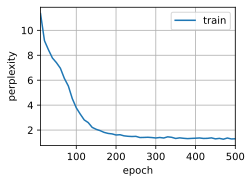

In [8]:
# RNN
# 设置RNN的隐藏单元数
num_hiddens = 256

# 创建RNN层，指定输入大小为词汇表大小，隐藏单元数为num_hiddens
rnn_layer = nn.RNN(len(vocab), num_hiddens)

# 尝试使用GPU，如果可用的话
device = d2l.try_gpu()

# 创建RNN模型，包含上面创建的RNN层，指定词汇表大小
net = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))

# 将模型移动到指定设备（GPU或CPU）
net = net.to(device)

# 设置训练的超参数
num_epochs, lr = 500, 1

# 创建计时器对象并开始计时
timer.start()

# 训练RNN模型，使用指定的数据迭代器、词汇表、学习率等
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

# 停止计时并记录时间
time_rnn = timer.stop()

# 打印训练时间
print('time_rnn:%.2f' % time_rnn)

perplexity 1.1, 224634.9 tokens/sec on cuda:0
time traveller for so it will mern acd merearen do not the sitio
travelleryou can show black is white by argument said filby
time_gru:25.25


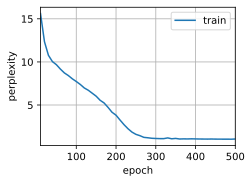

In [9]:
# 获取词汇表的大小
num_inputs = len(vocab)

# 创建GRU层，指定输入大小为词汇表大小，隐藏单元数为num_hiddens
gru_layer = nn.GRU(num_inputs, num_hiddens)

# 创建GRU模型，包含上面创建的GRU层，指定词汇表大小
model = d2l.RNNModel(gru_layer, len(vocab))

# 将模型移动到指定设备（GPU或CPU）
model = model.to(device)

# 创建计时器对象并开始计时
timer.start()

# 训练GRU模型，使用指定的数据迭代器、词汇表、学习率等
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# 停止计时并记录时间
time_gru = timer.stop()

# 打印训练时间
print('time_gru:%.2f' % time_gru)

|模型|困惑度|运行时间|
| -- | --- | ----- |
|RNN|1.3|19.71|
|GRU|1.1|25.25|

&emsp;&emsp;相较于RNN，GRU在重置门和更新门的计算，以及计算候选隐状态和确定最终隐状态的过程中增加了大量矩阵运算，这些新增的矩阵运算会使得模型的训练时间出现增加。但是得益于GRU中重置门与更新门的结构优势，GRU生成结果的困惑度仅为1.0，低于RNN中的1.3困惑度，输出字符串也更好。

### 练习 9.1.4

如果仅仅实现门控循环单元的一部分，例如，只有一个重置门或一个更新门会怎样？

**解答：**

In [10]:
import torch
from torch import nn
from d2l import torch as d2l

In [11]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """
    训练模型（定义见第8章）
    """
    # 交叉熵损失函数
    loss = nn.CrossEntropyLoss()

    # 初始化优化器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)

    # 预测函数
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)

    # 训练和预测
    for epoch in range(num_epochs):
        # 调用train_epoch_ch8函数进行一轮训练
        ppl, speed = d2l.train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        
        # 每10轮打印一次困惑度
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Perplexity: {ppl:.1f}')

    # 打印一个例子的预测结果
    print(predict('time traveller'))

    # 返回最终的困惑度值
    return ppl


In [12]:
# 仅重置门
def get_params_R(vocab_size, num_hiddens, device):
    # 设置输入和输出的数量
    num_inputs = num_outputs = vocab_size

    # 定义用于初始化参数的函数
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 定义一个辅助函数，用于初始化三个参数的元组
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    # 初始化重置门参数
    W_xr, W_hr, b_r = three()  # 重置门参数

    # 初始化候选隐状态参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数

    # 初始化输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 将所有参数放在一个列表中
    params = [W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]

    # 将梯度信息添加到所有参数中
    for param in params:
        param.requires_grad_(True)

    return params


In [13]:
def init_gru_state(batch_size, num_hiddens, device):
    # 初始化GRU状态，返回一个元组，包含一个形状为(batch_size, num_hiddens)的零张量
    return (torch.zeros((batch_size, num_hiddens), device=device), )

def gru(inputs, state, params):
    # 获取GRU的所有参数
    W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    
    # 从状态中获取隐层的值
    H, = state
    
    # 存储所有时间步的输出
    outputs = []
    
    # 遍历所有时间步
    for X in inputs:
        # Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        # 计算重置门
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        
        # 计算候选隐状态
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        
        # 更新隐状态
        H = H_tilda
        
        # 计算当前时间步的输出
        Y = H @ W_hq + b_q
        
        # 将输出添加到列表中
        outputs.append(Y)
    
    # 沿着时间步连接所有输出，并返回新的状态
    return torch.cat(outputs, dim=0), (H,)


perplexity 1.2, 61112.7 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black as alwaylofilby explacating im 


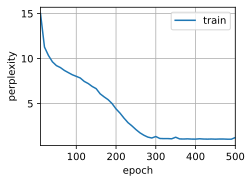

In [14]:
# 设置词汇表大小、隐藏单元数和设备（如果可用则使用GPU）
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()

# 设置训练轮数和学习率
num_epochs, lr = 500, 1

# 使用GRU从头开始创建一个RNN模型
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params_R,
                            init_gru_state, gru)

# 使用提供的数据迭代器、词汇表、学习率等训练模型
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [15]:
# 仅更新门
def get_params_Z(vocab_size, num_hiddens, device):
    # 设置输入和输出的数量
    num_inputs = num_outputs = vocab_size

    # 定义用于初始化参数的函数
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 定义一个辅助函数，用于初始化三个参数的元组
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    # 初始化更新门参数
    W_xz, W_hz, b_z = three()  # 更新门参数

    # 初始化候选隐状态参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数

    # 初始化输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 将所有参数放在一个列表中
    params = [W_xz, W_hz, b_z, W_xh, W_hh, b_h, W_hq, b_q]

    # 将梯度信息添加到所有参数中
    for param in params:
        param.requires_grad_(True)

    return params

In [16]:
def init_gru_state(batch_size, num_hiddens, device):
    # 初始化GRU状态，返回一个元组，包含一个形状为(batch_size, num_hiddens)的零张量
    return (torch.zeros((batch_size, num_hiddens), device=device), )

def gru(inputs, state, params):
    # 获取GRU的所有参数
    W_xz, W_hz, b_z, W_xh, W_hh, b_h, W_hq, b_q = params
    
    # 从状态中获取隐层的值
    H, = state
    
    # 存储所有时间步的输出
    outputs = []
    
    # 遍历所有时间步
    for X in inputs:
        # 计算更新门
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        
        # 计算候选隐状态
        H_tilda = torch.tanh((X @ W_xh) + (H @ W_hh) + b_h)
        
        # 更新隐状态
        H = Z * H + (1 - Z) * H_tilda
        
        # 计算当前时间步的输出
        Y = H @ W_hq + b_q
        
        # 将输出添加到列表中
        outputs.append(Y)
    
    # 沿着时间步连接所有输出，并返回新的状态
    return torch.cat(outputs, dim=0), (H,)

perplexity 1.1, 55200.0 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


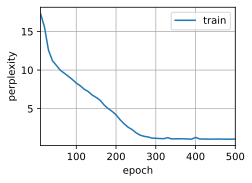

In [17]:
# 设置词汇表大小、隐藏单元数和设备（如果可用则使用GPU）
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()

# 设置训练轮数和学习率
num_epochs, lr = 500, 1

# 使用只包含更新门的GRU从头开始创建一个RNN模型
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params_Z,
                            init_gru_state, gru)

# 使用提供的数据迭代器、词汇表、学习率等训练模型
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)


&emsp;&emsp;门控循环单元（GRU）是一种递归神经网络，具有两个门控制状态的更新和重置，这些门可以控制输入的流入和隐藏状态的保留程度。如果仅实现其中一个门，则将无法实现完整的GRU模型。  

&emsp;&emsp;如果只实现了一个重置门，那么模型将只能重置隐藏状态，而无法更新其状态。这会导致模型无法学习长期依赖性并且可能无法产生准确的输出。  

&emsp;&emsp;如果只实现了一个更新门，则模型可以更新其隐藏状态，但是无法选择要丢弃的信息，这也可能会导致模型无法正确地处理长期依赖性。  

&emsp;&emsp;因此，为了实现GRU模型，需要同时实现更新门和重置门。这样，模型就能够更新其隐藏状态并选择要保留和丢弃的信息，从而使其能够正确地处理长期依赖性。

## 9.2 长短期记忆网络（LSTM） 

### 练习 9.2.1

调整和分析超参数对运行时间、困惑度和输出顺序的影响。

**解答：**

In [18]:
import torch
from torch import nn
from d2l import torch as d2l

In [19]:
# 定义模型超参数
# 超参数内容：[迭代周期，隐藏单元数，批量大小，小批量数据时间步数，学习率]
hyper_0 = [500, 512, 35, 32, 1]
hyper_1 = [250, 512, 35, 32, 1]
hyper_2 = [500, 256, 35, 32, 1]
hyper_3 = [500, 512, 10, 32, 1]
hyper_4 = [500, 512, 35, 10, 1]
hyper_5 = [500, 512, 35, 32, 0.01]
hyper_params = [hyper_0, hyper_1, hyper_2, hyper_3, hyper_4, hyper_5]

In [20]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""

    # 定义交叉熵损失用于计算损失
    loss = nn.CrossEntropyLoss()

    # animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
    #                         legend=['train'], xlim=[10, num_epochs])

    # 初始化优化器（SGD）以更新模型参数
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)

    # 定义生成基于训练模型的预测的函数
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)

    # 训练和预测循环在多个epoch上
    for epoch in range(num_epochs):
        # 对模型进行一个epoch的训练，并获取困惑度和速度
        ppl, speed = d2l.train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)

        # 如果要可视化训练进度，请取消注释以下行
        # if (epoch + 1) % 10 == 0:
        #     animator.add(epoch + 1, [ppl])

    # 打印训练后给定前缀（'time traveller'）的预测
    print(predict('time traveller'))

    # 返回训练后的困惑度
    return ppl


In [21]:
perplexity = []
times = []

# 遍历超参数列表
for i in range(len(hyper_params)):
    # 从超参数中获取参数值
    num_epochs, num_hiddens, batch_size, num_steps, lr = hyper_params[i]
    
    # 加载数据并创建迭代器和词汇表
    train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
    
    # 创建GRU层和RNN模型
    gru_layer = nn.GRU(len(vocab), num_hiddens)
    model = d2l.RNNModel(gru_layer, len(vocab))
    
    # 将模型移到GPU上（如果可用）
    model = model.to(d2l.try_gpu())
    
    # 创建计时器并开始计时
    timer = d2l.Timer()
    timer.start()
    
    # 训练模型并获取困惑度
    value = round(train_ch8(model, train_iter, vocab, lr, num_epochs, d2l.try_gpu()), 1)
    
    # 停止计时并记录时间
    time = timer.stop()
    
    # 将时间和困惑度添加到相应的列表中
    times.append(time)
    perplexity.append(value)
    
    # 打印结果
    print('hyper[%d]: Timer:%.2f, perplexity:%.1f' % (i, times[i], perplexity[i]))

time traveller proceeded anyreal body must have extension in fou
hyper[0]: Timer:13.66, perplexity:1.0
time traveller dimension diftermiver for the time traveller for 
hyper[1]: Timer:8.54, perplexity:2.3
time traveller came back andfilby s anecdote collapsedthe thing 
hyper[2]: Timer:13.14, perplexity:1.0
time traveller smiled round at us then still smiling faintlyand 
hyper[3]: Timer:66.95, perplexity:1.0
time traveller came back andfilby s anecdote collapsedthe thing 
hyper[4]: Timer:41.39, perplexity:1.0
time traveller   t  t  t  t  t  t  t  t  t  t  t  t  t  t  t  t 
hyper[5]: Timer:19.46, perplexity:16.7


|迭代周期|隐藏单元数|批量大小|小批量数据时间步数|学习率|困惑度|运行时间|
| ----- | ------- | ----- | --------------- | --- | ---- | ----- |
|500|512|35|32|1|1.0|13.66|
|250|512|35|32|1|2.3|8.54|
|500|256|35|32|1|1.0|13.14|
|500|512|10|32|1|1.0|66.95|
|500|512|35|10|1|1.0|41.39|
|500|512|35|32|0.01|16.7|19.46|

&emsp;&emsp;对比hyper[0]中的默认超参数配置，我们可以发现
- hyper[1]中缩小迭代周期，导致模型无法完全收敛，导致困惑度增大；
- hyper[2]中减少了隐藏层单元数，使得模型在很短时间内完成收敛，并且因为数据集较为简单的原因，困惑度也降低为1；
- hyper[3]中减小了批量大小，这使得模型的训练时间开销显著增加；
- hyper[4]中将小批量时间步的跨度缩小，虽然也造成了时间开销的增加，但少于批量减少带来的时间增长；
- hyper[5]中则对学习率进行了修改，可以发现过低的学习率会使得模型收敛的非常慢，造成困惑度暴涨。

&emsp;&emsp;综上可以发现，迭代周期和学习率的缩小会导致模型无法在对应周期内完成收敛，导致模型训练不完全，困惑度显著增加。批量大小即时间步跨度的降低则会导致模型每次加载少量数据，变相造成时间开销的增大；而对于简单的数据，采用一个简单的模型既可以降低时间开销，也可以使得模型很好收敛，确保性能。

### 练习 9.2.2

如何更改模型以生成适当的单词，而不是字符序列？

**解答：**

&emsp;&emsp;将文本的生成方式由字符序列改为单词，具体可采用以下方式：

In [22]:
import torch
from torch import nn
from d2l import torch as d2l

1. 词元化处理时采用单词级别的词元化处理，使得模型学会单词间的关系而非字符间的关系。

In [23]:
def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的词元索引列表和词表"""
    # 读取时光机器数据集的文本行
    lines = d2l.read_time_machine()
    
    # 将文本行进行分词，得到词元列表
    tokens = d2l.tokenize(lines, 'word')
    
    # 创建词表（Vocabulary）对象
    vocab = d2l.Vocab(tokens)
    
    # 将词元列表转换为词元索引列表
    corpus = [vocab[token] for line in tokens for token in line]
    
    # 如果指定了max_tokens，截取corpus的长度
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    
    # 返回词元索引列表和词表
    return corpus, vocab

# 调用load_corpus_time_machine函数加载时光机器数据集
corpus, vocab = load_corpus_time_machine()

# 输出词元索引列表和词表的长度
len(corpus), len(vocab)


(32775, 4580)

2. 使用双向语言模型，将前后文的单词序列纳入考虑范围，实现根据上下文预测单词，获得更准确的输出。  
&emsp;&emsp;`lstm_layer = nn.LSTM(num_inputs, num_hiddens, bidirectional=True)`

3. 使用WordEmbedding取代One-hot，将单词映射到向量空间，保留了近义词之间的相关性，可以学习单词间的语义关系，更准确的生成单词。

In [24]:
class RNNModel_Embedding(nn.Module):
    """使用嵌入层的RNN模型"""

    def __init__(self, rnn_layer, vocab_size, embedding_dim, **kwargs):
        super(RNNModel_Embedding, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 如果RNN是双向的，`num_directions`应为2，否则为1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        """定义前向传播逻辑"""
        # 将输入通过嵌入层转换为词嵌入向量
        X = self.embedding(inputs.T.long())
        X = X.to(torch.float32)
        
        # 将词嵌入向量传入RNN层，得到输出
        Y, state = self.rnn(X, state)

        # 全连接层将输出变换为形状为(`num_steps` * `batch_size`, `vocab_size`)的张量
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        """初始化RNN的隐藏状态"""
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU`接受一个张量作为隐藏状态
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens),
                               device=device)
        else:
            # `nn.LSTM`接受一个元组作为隐藏状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [25]:
class SeqDataLoader:
    """用于加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        """初始化函数"""
        # 根据 use_random_iter 决定使用随机迭代还是顺序迭代
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        # 加载时光机器数据集
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        """返回迭代器"""
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词汇表"""
    # 创建 SeqDataLoader 对象
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    # 返回迭代器和词汇表
    return data_iter, data_iter.vocab

In [26]:
# 设置批量大小、时间步数和设备（如果可用则使用GPU）
batch_size, num_steps, device = 32, 35, d2l.try_gpu()

# 加载时光机器数据集的迭代器和词汇表
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

# 设置输入维度（词汇表大小）、隐藏单元数和嵌入维度
num_inputs, num_hiddens = len(vocab), 512
embedding_dim = len(vocab)

# 设置LSTM层的层数和创建LSTM层
num_layers = 2
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)

# 创建使用嵌入层的RNN模型
model = RNNModel_Embedding(lstm_layer, len(vocab), embedding_dim=embedding_dim)

# 将模型移动到指定设备（GPU或CPU）
model = model.to(device)

In [27]:
def predict_word(prefix, num_preds, net, vocab, device):
    """根据给定的前缀生成新单词"""
    # 初始化模型的隐藏状态
    state = net.begin_state(batch_size=1, device=device)
    
    # 将前缀的第一个词加入输出列表
    outputs = [vocab[prefix[0]]]
    
    # 定义一个函数用于获取模型的输入
    get_input = lambda: d2l.reshape(d2l.tensor(
        [outputs[-1]], device=device), (1, 1))
    
    # 进行预热期，通过前缀进行模型的预热
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    
    # 开始生成新单词
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        word_idx = int(y.argmax(dim=1).reshape(1))
        word = vocab.idx_to_token[word_idx]
        
        # 跳过未知单词
        if word == '<unk>':
            continue
        
        # 将预测的单词加入输出列表
        outputs.append(word_idx)
        
        # 如果预测的单词以空格结尾，则停止
        if word.endswith(' '):
            break
    
    # 将输出的单词索引列表转换为字符串
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [28]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    # 使用交叉熵损失作为损失函数
    loss = nn.CrossEntropyLoss()
    
    # 创建一个动画器（animator）用于可视化训练过程
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    
    # 初始化优化器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    
    # 定义一个用于生成预测的函数
    predict = lambda prefix: predict_word(prefix, 50, net, vocab, device)
    
    # 训练和预测
    for epoch in range(num_epochs):
        # 使用d2l.train_epoch_ch8进行模型训练
        ppl, speed = d2l.train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        
        # 每隔10个周期生成一些预测结果并添加到动画中
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    
    # 打印最终的困惑度和训练速度
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    
    # 打印最终的预测结果
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.0, 14810.7 tokens/sec on cuda:0
tim<unk><unk>t<unk>av<unk><unk><unk><unk><unk>andyetbyyetbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyh
t<unk>av<unk><unk><unk><unk><unk>andyetbyyetbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyhbyh


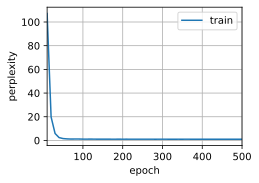

In [29]:
# 设置训练的超参数：训练周期数和学习率
num_epochs, lr = 500, 1

# 调用train_ch8函数进行模型训练
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

&emsp;&emsp;在相同的超参数训练下，使用单词会比使用字符串更快地拟合，从非常高的困惑值在相较于使用字符串更短的迭代次数下降到 `1.0` 的困惑值。

### 练习 9.2.3

在给定隐藏层维度的情况下，比较门控循环单元、长短期记忆网络和常规循环神经网络的计算成本。要特别注意训练和推断成本。

**解答：**

&emsp;&emsp;将隐藏层维度统一设置为256

In [30]:
# [迭代周期，隐藏单元数，批量大小，小批量数据时间步数，学习率]
num_epochs, num_hiddens, batch_size, num_steps, lr = [500, 256, 35, 32, 1]
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [31]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """
    训练模型（定义见第8章）
    """
    # 交叉熵损失函数
    loss = nn.CrossEntropyLoss()

    # 初始化优化器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)

    # 预测函数
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)

    # 训练和预测
    for epoch in range(num_epochs):
        # 调用train_epoch_ch8函数进行一轮训练
        ppl, speed = d2l.train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        
        # 每10轮打印一次困惑度
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Perplexity: {ppl:.1f}')

    # 打印一个例子的预测结果
    print(predict('time traveller'))

    # 返回最终的困惑度值
    return ppl


perplexity 1.3, 358070.8 tokens/sec on cuda:0
time traveller smiled round at us then still smilissiepare haing
traveller carexdineculencas ingrame trout maineplyou difent
Timer: 18.04


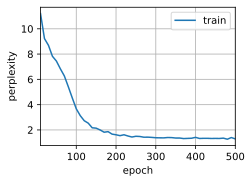

In [32]:
#RNN
import torch.nn as nn
import d2l.torch as d2l

# 使用指定的词汇表大小和隐藏单元数量定义一个RNN层
rnn_layer = nn.RNN(len(vocab), num_hiddens)

# 使用定义好的RNN层创建一个RNN模型
rnn = d2l.RNNModel(rnn_layer, len(vocab))

# 如果GPU可用，将模型移动到GPU上
rnn = rnn.to(d2l.try_gpu())

# 初始化一个计时器来跟踪训练时间
timer = d2l.Timer()
timer.start()

# 使用训练迭代器、词汇表、学习率和训练轮数训练RNN模型
d2l.train_ch8(rnn, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

# 停止计时器并打印经过的时间
time = timer.stop()
print('Timer: %.2f' % time)

perplexity 1.0, 281955.2 tokens/sec on cuda:0
time traveller came back andfilby s anecdote collapsedthe thing 
traveller proceeded anyreal body must have extension in fou
Timer: 23.38


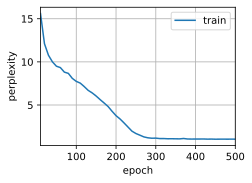

In [33]:
# GRU
import torch.nn as nn
import d2l.torch as d2l

# 使用指定的词汇表大小和隐藏单元数量定义一个GRU层
gru_layer = nn.GRU(len(vocab), num_hiddens)

# 使用定义好的GRU层创建一个GRU模型
gru = d2l.RNNModel(gru_layer, len(vocab))

# 如果GPU可用，将模型移动到GPU上
gru = gru.to(d2l.try_gpu())

# 初始化一个计时器来跟踪训练时间
timer = d2l.Timer()
timer.start()

# 使用训练迭代器、词汇表、学习率和训练轮数训练GRU模型
d2l.train_ch8(gru, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

# 停止计时器并打印经过的时间
time = timer.stop()
print('Timer: %.2f' % time)


perplexity 1.1, 229065.6 tokens/sec on cuda:0
time traveller came back andfilby s anecdote collapsedthe thing 
traveller came back andfilby s anecdote collapsedthe thing 
Timer: 24.11


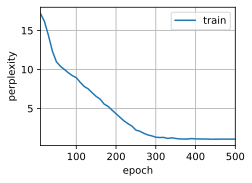

In [34]:
# LSTM
import torch.nn as nn
import d2l.torch as d2l

# 使用指定的词汇表大小和隐藏单元数量定义一个LSTM层
lstm_layer = nn.LSTM(len(vocab), num_hiddens)

# 使用定义好的LSTM层创建一个LSTM模型
lstm = d2l.RNNModel(lstm_layer, len(vocab))

# 如果GPU可用，将模型移动到GPU上
lstm = lstm.to(d2l.try_gpu())

# 初始化一个计时器来跟踪训练时间
timer = d2l.Timer()
timer.start()

# 使用训练迭代器、词汇表、学习率和训练轮数训练LSTM模型
d2l.train_ch8(lstm, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

# 停止计时器并打印经过的时间
time = timer.stop()
print('Timer: %.2f' % time)


| 模型 | 困惑度 | 运行时间 |
| ---- | ----- | ---- |
|RNN|1.3|18.04|
|GRU|1.0|23.38|
|LSTM|1.1|24.11|

&emsp;&emsp;可以从上述表中看出结构最简单的RNN所需计算成本最低，运行时间最短。GRU在RNN基础上增加了更新门和重置门两个门控单元，结构复杂，参数量也有所增加，所需的计算成本要大于RNN，运行时间也更长，但困惑度有随之降低，模型准确度更高。而LSTM内含输入门、输出门以及遗忘门3个门，结构进一步复杂化，计算成本也是三个模型中最高的。

### 练习 9.2.4  

既然候选记忆元通过使用 $\tanh$ 函数来确保值范围在 $(-1,1)$ 之间，那么为什么隐状态需要再次使用 $\tanh$ 函数来确保输出值范围在 $(-1,1)$ 之间呢？

**解答：**

&emsp;&emsp;在整个LSTM计算中，候选记忆元 $\tilde{C}_t$ 的计算公式 $9.2.2$：
$$\tilde{C}_t=\tanh(X_tW_{xc}+H_{t-1}W_{hc}+b_c)$$
&emsp;&emsp;此时 $\tanh$ 为激活函数，确保 $\tilde{C}_t$ 的值域在 $(-1,1)$ 之间。  

&emsp;&emsp;而在计算记忆元 $C_t$ 时，存在输入门和遗忘门对记忆元的值进行影响，具体计算公式 $9.2.3$ 如下：
$$C_t=F_t \odot C_{t-1}+I_t \odot \tilde{C}_t$$
&emsp;&emsp;上述公式中，输入门和遗忘门的值域为 $(0,1)$ ，因此当 $F_t$、$I_t$ 的值均为 $1$ ，且 $C_{t-1}、\tilde{C}_t$ 的值也均为 $1$ 时，整个记忆元的最终输出结果为 $2$ 。此时对于整个隐状态而言，由于输出门的值域也为 $(0,1)$ ，因此隐状态值很有可能超过 $1$ ，因此需要对记忆元通过 $\tanh$ 函数来进行约束取值范围，以此确保输出值范围在 $(-1,1)$ 之间。

### 练习 9.2.5

实现一个能够基于时间序列进行预测而不是基于字符序列进行预测的长短期记忆网络模型。


**解答：**

&emsp;&emsp;这里使用[8.1.序列模型](https://zh.d2l.ai/chapter_recurrent-neural-networks/sequence.html#id11)中的序列数据

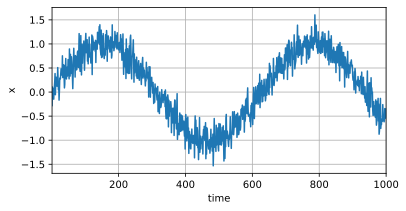

In [35]:
%matplotlib inline
# 导入必要的库
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# 定义总共产生1000个点的时间序列长度
T = 1000

# 生成包含从1到1000的浮点数的时间序列
time = torch.arange(1, T + 1, dtype=torch.float32)

# 创建一个正弦波形，并向其添加均值为0、标准差为0.2的噪声
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))

# 使用 d2l.plot 函数将时间序列可视化为图表
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [36]:
tau = 4  # tau定义了用于预测的时间步数
features = torch.zeros((T - tau, tau))

# 从原始时间序列 x 中提取特征
for i in range(tau):
    features[:, i] = x[i: T - tau + i]

# 提取标签（即下一个时间步的值）
labels = x[tau:].reshape((-1, 1))

# 定义批量大小和训练样本数量
batch_size, n_train = 16, 600

# 创建训练迭代器，仅使用前 n_train 个样本进行训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)


In [37]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        # 定义LSTM层，输入维度为input_size，隐藏单元数量为hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)

        # 定义线性层，将LSTM输出映射到输出维度为output_size
        self.linear = nn.Linear(hidden_size, output_size)

        # 保存隐藏单元数量
        self.hidden_size = hidden_size

    def forward(self, input):
        # 将输入视图变形为 (sequence_length, batch_size, input_size)
        lstm_out, _ = self.lstm(input.view(len(input), 1, -1))

        # 将LSTM输出变形为 (sequence_length, hidden_size)，并通过线性层得到最终输出
        output = self.linear(lstm_out.view(len(input), -1))

        return output

In [38]:
input_size = 4
hidden_size = 200
output_size = 1
learning_rate = 0.01
epochs = 50

In [39]:
# 定义模型，input_size为输入维度，hidden_size为隐藏单元数量，output_size为输出维度
model = LSTM(input_size, hidden_size, output_size)

# 定义损失函数为均方误差损失
criterion = nn.MSELoss()

# 打印模型结构
print(model)

LSTM(
  (lstm): LSTM(4, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)


In [40]:
def train(model, train_iter, loss, epochs, learning_rate):
    # 使用Adam优化器
    trainer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        for X, y in train_iter:
            # 将梯度归零
            trainer.zero_grad()

            # 前向传播
            output = model(X)

            # 计算损失
            loss = criterion(output, y)

            # 反向传播和优化
            loss.backward()
            trainer.step()

        # 打印当前训练轮数和损失
        if (epoch+1) % 5 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, epochs, loss.item()))

In [41]:
train(model, train_iter, criterion, 50, 0.01)

Epoch [5/50], Loss: 0.0947
Epoch [10/50], Loss: 0.0438
Epoch [15/50], Loss: 0.0522
Epoch [20/50], Loss: 0.0907
Epoch [25/50], Loss: 0.0359
Epoch [30/50], Loss: 0.0244
Epoch [35/50], Loss: 0.0604
Epoch [40/50], Loss: 0.0264
Epoch [45/50], Loss: 0.0473
Epoch [50/50], Loss: 0.0402


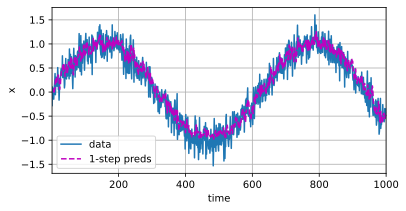

In [42]:
# 通过模型生成一步预测
onestep_preds = model(features)

# 使用 d2l.plot 函数将原始数据和一步预测可视化为图表
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

&emsp;&emsp;从上图我们可以看到基于长短期记忆网络模型预测出来的结果在时间序列问题也能有良好的表现，能过很好地拟合所提供的序列数据。  

## 9.3 深度循环神经网络 

### 练习 9.3.1 

基于我们在8.5节中讨论的单层实现，尝试从零开始实现两层循环神经网络。

**解答：**

模型结构：

[输入层]\
[第一层RNN] --> (H1)\
[第二层RNN] --> (H2)\
[输出层]

In [43]:
# 定义训练数据
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [44]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """
    训练模型（定义见第8章）
    """
    # 交叉熵损失函数
    loss = nn.CrossEntropyLoss()

    # 初始化优化器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)

    # 预测函数
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)

    # 训练和预测
    for epoch in range(num_epochs):
        # 调用train_epoch_ch8函数进行一轮训练
        ppl, speed = d2l.train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        
        # 每10轮打印一次困惑度
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Perplexity: {ppl:.1f}')

    # 打印一个例子的预测结果
    print(predict('time traveller'))

    # 返回最终的困惑度值
    return ppl


In [45]:
# 初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 第一层RNN参数
    W_xh1 = normal((num_inputs, num_hiddens))
    W_hh1 = normal((num_hiddens, num_hiddens))
    b_h1 = torch.zeros(num_hiddens, device=device)
    
    # 第二层RNN参数
    W_hh2 = normal((num_hiddens, num_hiddens))
    b_h2 = torch.zeros(num_hiddens, device=device)

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 将参数放在一个列表中
    params = [W_xh1, W_hh1, b_h1, W_hh2, b_h2, W_hq, b_q]

    # 将参数的requires_grad属性设置为True，以便进行梯度计算
    for param in params:
        param.requires_grad_(True)

    return params

In [46]:
def init_rnn_state(batch_size, num_hiddens, device):
    # 返回初始化的双层RNN状态
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

&emsp;&emsp;定义一个双层RNN网络

In [47]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh1, W_hh1, b_h1, W_hh2, b_h2, W_hq, b_q = params
    H1, H2 = state
    outputs = []

    # X的形状：(批量大小，词表大小)
    for X in inputs:
        # 第一层RNN的计算
        H1 = torch.relu(torch.mm(X, W_xh1) + torch.mm(H1, W_hh1) + b_h1)
        # 第二层RNN的计算
        H2 = torch.relu(torch.mm(H1, W_hh2) + b_h2)
        # 输出层的计算
        Y = torch.mm(H2, W_hq) + b_q
        outputs.append(Y)

    # 将所有输出连接在一起
    return torch.cat(outputs, dim=0), (H1, H2)


In [48]:
num_hiddens = 512
net = d2l.RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)

perplexity 1.0, 51951.0 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


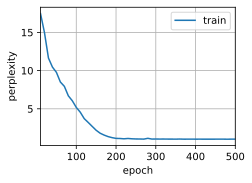

In [49]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

### 练习 9.3.2

在本节训练模型中，比较使用门控循环单元替换长短期记忆网络后模型的精确度和训练速度。

**解答：**

In [50]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [51]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """
    训练模型（定义见第8章）
    """
    # 交叉熵损失函数
    loss = nn.CrossEntropyLoss()

    # 初始化优化器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)

    # 预测函数
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)

    # 训练和预测
    for epoch in range(num_epochs):
        # 调用train_epoch_ch8函数进行一轮训练
        ppl, speed = d2l.train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        
        # 每10轮打印一次困惑度
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Perplexity: {ppl:.1f}')

    # 打印一个例子的预测结果
    print(predict('time traveller'))

    # 返回最终的困惑度值
    return ppl


In [52]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()

# 定义LSTM层
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)

# 创建RNN模型
model = d2l.RNNModel(lstm_layer, len(vocab))

# 将模型移动到GPU（如果可用）
model = model.to(device)

perplexity 1.0, 162486.3 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby
LSTM_Timer: 34.48


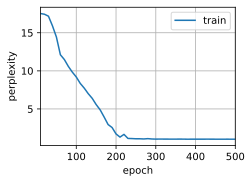

In [53]:
num_epochs, lr = 500, 2
timer = d2l.Timer()
timer.start()

d2l.train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)

time = timer.stop()
print('LSTM_Timer: %.2f' % time)

In [54]:
# 定义GRU层
gru_layer = nn.GRU(num_inputs, num_hiddens, num_layers)

# 创建RNN模型，使用定义的GRU层和词表大小
model_gru = d2l.RNNModel(gru_layer, len(vocab))

# 将模型移动到指定的设备（GPU或CPU）
model_gru = model_gru.to(device)

perplexity 1.0, 182671.3 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby
GRU_Timer: 31.36


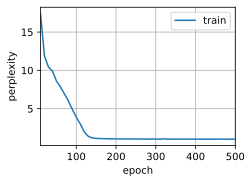

In [55]:
num_epochs, lr = 500, 2
timer = d2l.Timer()
timer.start()

d2l.train_ch8(model_gru, train_iter, vocab, lr*1.0, num_epochs, device)

time = timer.stop()
print('GRU_Timer: %.2f'%time)

&emsp;&emsp;对比双层GRU与双层LSTM的结果可以发现，将LSTM替换为GRU后模型的训练速度有所提高，因为相较于LSTM，GRU只有两个门，具有更少的参数量，因此训练速度更快。精确度方面，由于文本量限制，二者都在该文本上达到了1.0的困惑度，并未出现明显差别。

### 练习 9.3.3

如果增加训练数据，能够将困惑度降到多低？

**解答：**

&emsp;&emsp;这里将该作者的另一篇文章[《The War of the Worlds》](https://github.com/datawhalechina/d2l-ai-solutions-manual/blob/master/notebooks/data/the%20war%20of%20the%20worlds.txt)与[《The Time Machine》](https://github.com/datawhalechina/d2l-ai-solutions-manual/blob/master/notebooks/data/timemachine.txt)进行混合，将增加后的文本作为训练数据。

In [56]:
import torch
from torch import nn
from d2l import torch as d2l
import re

In [57]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """
    训练模型（定义见第8章）
    """
    # 交叉熵损失函数
    loss = nn.CrossEntropyLoss()

    # 初始化优化器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)

    # 预测函数
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)

    # 训练和预测
    for epoch in range(num_epochs):
        # 调用train_epoch_ch8函数进行一轮训练
        ppl, speed = d2l.train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        
        # 每10轮打印一次困惑度
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Perplexity: {ppl:.1f}')

    # 打印一个例子的预测结果
    print(predict('time traveller'))

    # 返回最终的困惑度值
    return ppl


这里的 [Mix_data.txt](https://github.com/datawhalechina/d2l-ai-solutions-manual/blob/master/notebooks/data/Mix_data.txt) 是上述两篇文章结合后的文件

In [58]:
def read_Mix():
    # 读取文件 Mix_data.txt 中的文本数据
    with open('../../notebooks/data/Mix_data.txt', 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    # 对每一行进行处理，去除非字母字符，转换为小写
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def load_corpus_world(max_tokens=-1):
    # 通过 read_Mix 函数获取文本数据
    lines = read_Mix()
    
    # 使用 d2l.tokenize 函数将文本行划分为字符
    tokens = d2l.tokenize(lines, 'char')
    
    # 使用 d2l.Vocab 创建词汇表
    vocab = d2l.Vocab(tokens)

    # 将每个字符转换为词汇表中的索引，形成语料库
    corpus = [vocab[token] for line in tokens for token in line]
    
    # 如果指定了 max_tokens，限制语料库的大小
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    
    # 返回处理后的语料库和词汇表
    return corpus, vocab

In [59]:
class SeqDataLoader:
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        # 根据 use_random_iter 的值选择数据迭代函数
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential

        # 从文件加载语料库和词汇表
        self.corpus, self.vocab = load_corpus_world(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        # 返回数据迭代函数的迭代器
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_mix_data(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    # 创建 SeqDataLoader 实例作为数据迭代器
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    
    # 返回数据迭代器和对应的词汇表
    return data_iter, data_iter.vocab


In [60]:
# 设置训练参数：batch_size 和 num_steps
batch_size, num_steps = 32, 35

# 调用 load_mix_data 函数加载数据迭代器和词汇表
train_iter, vocab = load_mix_data(batch_size, num_steps)

# 设置 LSTM 模型的参数
num_inputs, num_hiddens, num_layers = len(vocab), 256, 2

# 尝试使用 GPU
device = d2l.try_gpu()

# 创建 LSTM 层
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)

# 创建 RNN 模型，将其移动到指定设备
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

perplexity 1.0, 174917.2 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


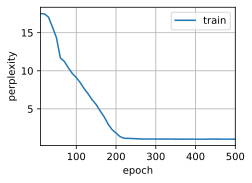

In [61]:
# 设置训练参数：num_epochs（训练轮数）和 lr（学习率）
num_epochs, lr = 500, 2

# 调用 d2l.train_ch8 函数进行模型训练
d2l.train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)

&emsp;&emsp;当数据量为96135字时，LSTM模型的困惑度仍然能够降低至1

### 练习 9.3.4

在为文本建模时，是否可以将不同作者的源数据合并？有何优劣呢？

**解答：**

&emsp;&emsp;在为文本建模时，将不同作者的源数据合并是可以的，但需要考虑一些因素。  
- 优点：
    - 增加训练数据量：将不同作者的源数据合并，可以增加训练数据量，从而更好地训练模型。[1,3]
    - 提高模型泛化能力：不同作者的风格、语言等可能不同，将这些数据合并可以让模型更好地学习到不同的文本特征，提高模型的泛化能力。  

- 缺点：
    - 可能影响模型训练效果：合并不同作者的数据，可能会引入更多的噪音，使得模型更难学习到有用的信息，从而影响训练效果。[2]  
    - 可能会引入偏见：如果不同作者的数据不平衡，比如某一位作者的数据量比其他作者多很多，那么训练出来的模型可能会对该作者的文本表现更好，从而引入偏见。

&emsp;&emsp;综上所述，将不同作者的源数据合并在一起是可以的，但需要在合并前考虑好数据的平衡性和质量，并对数据进行适当的预处理，以确保训练出来的模型具有较好的泛化能力和稳定性。

---

[1] Peng, N., & Dredze, M. (2016). Improving named entity recognition for chinese social media with word segmentation representation learning. arXiv preprint arXiv:1603.00786.\
[2] Kadadi, A., Agrawal, R., Nyamful, C., & Atiq, R. (2014, October). Challenges of data integration and interoperability in big data. In 2014 IEEE international conference on big data (big data) (pp. 38-40). IEEE.\
[3] Kobayashi, H., Sakamoto, M., Nakashima, A., Hirayu, K., & Ikawa, S. (2023). U.S. Patent Application No. 17/455,514.

## 9.4 双向循环神经网络 

### 练习 9.4.1

如果不同方向使用不同数量的隐藏单位，$\mathbf{H_t}$ 的形状会发生怎样的变化？

**解答：**

&emsp;&emsp;在双向循环神经网络中，最终隐藏状态 $H_t$ 的维度由前向循环神经网络和反向循环神经网络中的隐藏层进行 $Concat$ 得来，而通常前向和反向循环神经网络均选用相同的隐藏层数量，即    $\overrightarrow{H_t}=\overleftarrow{H_t}$ ，因此直接进行翻倍，即可获得最终形状 $H_t=2 * \overrightarrow{H_t} = 2 * \overleftarrow{H_t}$ 。  
&emsp;&emsp;而当不同方向使用不同数量的隐藏单位时，此时前向和反向的隐藏单元数量不同， $H_t$ 的维度并不等于前向或反向循环神经网络中隐藏层数量的 $2$ 倍，此时需要将前向和反向的隐藏层维度拼接相加，获得最终 $H_t$ 的维度，即 $H_t = \overrightarrow{H_t} + \overleftarrow{H_t}$ 

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size_forward, hidden_size_backward, num_layers=1):
        super(BiLSTM, self).__init__()

        # 定义前向LSTM层
        # batch_first=True 意味着输入形状为 [batch_size, seq_length, feature_dim]
        self.lstm_forward = nn.LSTM(input_size, hidden_size_forward, num_layers=num_layers, batch_first=True)
        
        # 定义反向LSTM层
        self.lstm_backward = nn.LSTM(input_size, hidden_size_backward, num_layers=num_layers, batch_first=True)

    def forward(self, x, x_lengths):
        # 前向部分
        # pack_padded_sequence() 负责将可变长度序列进行打包
        packed_x_forward = nn.utils.rnn.pack_padded_sequence(x, x_lengths, batch_first=True, enforce_sorted=False)
        packed_h_forward, _ = self.lstm_forward(packed_x_forward)
        
        # pad_packed_sequence() 负责将填充的序列解包，以便在后续计算时去掉无用的填充部分
        h_forward, _ = nn.utils.rnn.pad_packed_sequence(packed_h_forward, batch_first=True)

        # 反向部分
        # flip() 用于颠倒序列中的元素，以便进行反向LSTM计算
        packed_x_backward = nn.utils.rnn.pack_padded_sequence(torch.flip(x, [1]), x_lengths, batch_first=True, enforce_sorted=False)
        packed_h_backward, _ = self.lstm_backward(packed_x_backward)
        
        # pad_packed_sequence() 解包填充的序列
        h_backward, _ = nn.utils.rnn.pad_packed_sequence(packed_h_backward, batch_first=True)
        
        # 反转反向LSTM的输出以匹配正向LSTM
        h_backward = torch.flip(h_backward, [1])

        # Concatenate 正向和反向LSTM的输出
        h = torch.cat((h_forward, h_backward), dim=2)

        return h

In [63]:
# 定义模型和输入参数
batch_size = 3
seq_length = 5
input_size = 2
hidden_size_forward = 10
hidden_size_backward = 8

# 构造不同长度的输入序列
x_lengths = [3, 5, 2]
x = [torch.randn(x_lengths[i], input_size) for i in range(batch_size)]

# 使用 pad_sequence 进行填充，使得输入序列具有相同的长度
x = nn.utils.rnn.pad_sequence(x, batch_first=True)

# 创建 BiLSTM 模型
model = BiLSTM(input_size, hidden_size_forward, hidden_size_backward)
print(model)

# 进行前向传播
h = model(x, x_lengths)
print(h.shape)

BiLSTM(
  (lstm_forward): LSTM(2, 10, batch_first=True)
  (lstm_backward): LSTM(2, 8, batch_first=True)
)
torch.Size([3, 5, 18])


&emsp;&emsp;从这里我们可以发现到当前向和反向的隐藏节点不同的时候， $H_t$ 最终的形状会是 $\overrightarrow{H_t} + \overleftarrow{H_t}$。即前向中的 $10$ 和反向中的 $8$ 得出 $10+8=18$。

### 练习 9.4.2

设计一个具有多个隐藏层的双向循环神经网络。

**解答：**

In [64]:
import torch
from torch import nn
from d2l import torch as d2l

# 加载数据
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# 定义模型参数
vocab_size, num_hiddens, num_layers = len(vocab), 256, 4
num_inputs = vocab_size

# 创建双向LSTM层
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)

# 创建 RNN 模型，将其移动到指定设备
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

# 打印模型结构
print(model)

RNNModel(
  (rnn): LSTM(28, 256, num_layers=4, bidirectional=True)
  (linear): Linear(in_features=512, out_features=28, bias=True)
)


&emsp;&emsp;在上述模型中，隐藏层的数量被设置为4，实现了一个四层的双向循环神经网络。

### 练习 9.4.3

在自然语言中一词多义很常见。例如，“bank” 一词在不同的上下文 “I went to the bank to deposit cash” 和 “I went to the bank to sit down” 中有不同的含义。如何设计一个神经网络模型，使其在给定上下文序列和单词的情况下，返回该单词在此上下文中的向量表示？哪种类型的神经网络架构更适合处理一词多义？

**解答：**

&emsp;&emsp;处理一词多义的常见方法是结合上下文信息来对该位置的单词意思进行确认，例如在神经网络中，可以采用双向循环神经网络模型或者Transformer，将上下文中的单词序列映射到单词的向量表示。这些模型可以学到上下文中单词的复杂交互，以此实现根据上下文内容来动态生成单词的对应向量表示。  

&emsp;&emsp;这些上下文感知的双向模型能够更好地捕捉单词在不同上下文中的含义。例如，在双向LSTM中，每个单词的向量表示取决于整个上下文序列，因此可以更好地捕捉单词在上下文中的含义。

---

[1] Sarzynska-Wawer, J., Wawer, A., Pawlak, A., Szymanowska, J., Stefaniak, I., Jarkiewicz, M., & Okruszek, L. (2021). Detecting formal thought disorder by deep contextualized word representations. Psychiatry Research, 304, 114135.\
[2] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.

## 9.5 机器翻译与数据集 

### 练习 9.5.1

在`load_data_nmt`函数中尝试不同的`num_examples`参数值。这对源语言和目标语言的词表大小有何影响？

**解答：**

In [ ]:
import os
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

#@save
def load_data_nmt(batch_size, num_steps, num_examples):
    """返回翻译数据集的迭代器和词表"""
    text = d2l.preprocess_nmt(read_data_nmt())
    source, target = d2l.tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = d2l.build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = d2l.build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [ ]:
num_examples = [100, 200, 300, 400, 500, 600]
src = []
tgt = []
for i in num_examples:
    train_iter_2, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8, num_examples=i)
    src.append(len(src_vocab))
    tgt.append(len(tgt_vocab))

print(src, tgt)

[40, 69, 102, 130, 159, 184] [40, 67, 107, 125, 163, 201]


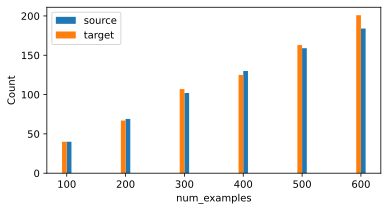

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.bar(num_examples, src, width=8, align='edge', label='source')
ax.bar(num_examples, tgt, width=-8, align='edge', label='target')
ax.set_xlabel('num_examples')
ax.set_ylabel('Count')
ax.legend()
plt.show()

&emsp;&emsp;在tokenize_nmt函数中，num_examples主要用于规定进行词元化的序列的长度，因此num_examples越大，所获得的词表越大。

### 练习 9.5.2

某些语言（例如中文和日语）的文本没有单词边界指示符（例如空格）。对于这种情况，单词级词元化仍然是个好主意吗？为什么？

**解答：**

&emsp;&emsp;以中文为例，中文中不存在类似空格这样的单词边界指示符，但是中文可采用基于词典、基于规则或者基于统计的分词方法，针对中文文本进行分词，以此实现中文的词元化处理。  
&emsp;&emsp;这种方法可以将中文文本划分为单独的词语，以实现对中文的精确处理。例如在词义消歧时，单词级的中文分词可以帮助我们更准确的确定词语的上下文，以此来确定歧义词的准确意义。并且在信息检索任务中，很多检索都是基于关键词展开的，对中文进行单词级词元化，可以便于在索引中进行文本匹配。因此，即便中文和日语这些语言中没有单词边界指示符，但在进行自然语言处理时，单词级的词元化仍是非常关键的一步。

## 9.6 编码器-解码器架构

### 练习 9.6.1

假设我们使用神经网络来实现“编码器－解码器”架构，那么编码器和解码器必须是同一类型的神经网络吗？

**解答：**

&emsp;&emsp;不一定。虽然编码器和解码器通常是相同类型的神经网络，但它们可以是不同的网络架构。事实上，有些最先进的神经网络模型在编码器和解码器之间使用了不同的架构。例如，使用CNN作为编码器，然后使用RNN或Transformer作为解码器的架构在机器翻译任务中很常见。  
&emsp;&emsp;另外，编码器和解码器也可以在不同的领域应用不同类型的神经网络。例如，在图像到文本任务中，可以使用CNN作为编码器，将图像编码为特征向量，然后使用RNN或Transformer作为解码器生成相应的自然语言描述。因此，编码器和解码器可以是同一类型的神经网络，也可以是不同类型的神经网络，它实质上只是一种抽象的结构，该结构可以适用于多种神经网络，具体选择需要取决于具体的任务需求和设计思路。

### 练习 9.6.2

除了机器翻译，还有其它可以适用于”编码器－解码器“架构的应用吗？

**解答：**

&emsp;&emsp;目前，“编码器-解码器”结构已经在多种任务中取得了优秀的研究成果，并非仅仅局限于机器翻译一类任务中。例如语音识别任务，可以采用编码器接受音频信号，并将其编码为特征向量，再由解码器将其转化为文本内容；在图像生成任务中，编码器可以将输入的图像或文本内容进行编码，再由解码器根据编码的特征向量生成对应的图像；此外还有文本生成任务，编码器将输入文本进行编码后，再由解码器使用这些编码后的特征向量进行解码，生成与原始文本内容相似的文本。  
&emsp;&emsp;实际上，“编码器-解码器”是一个通用的抽象架构，其基本思想是将输入数据编码为一个便于神经网络学习和理解的中间表示，再由解码器将中间表示转换为所需要的输出。这种架构可以根据具体需求适用于不同的实际场景中。

## 9.7 序列到序列的学习（seq2seq） 

### 练习 9.7.1

试着通过调整超参数来改善翻译效果。

**解答：**

&emsp;&emsp;尝试将隐藏层和Embedding层维度修改为256，同时将batch_size修改为256，学习率降低至0.001

In [ ]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

loss 0.017, 24766.6 tokens/sec on cuda:0


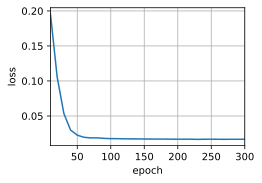

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.1
batch_size, num_steps = 256, 10
lr, num_epochs, device = 0.001, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est mouillé mouillé ., bleu 0.548
i'm home . => je suis chez <unk> moi qui ai ai <unk> gagné, bleu 0.434


### 练习 9.7.2

重新运行实验并在计算损失时不使用遮蔽，可以观察到什么结果？为什么会有这个结果？

**解答：**

In [ ]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        # weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [ ]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 2.3026, 2.3026])

In [ ]:
loss_s = d2l.MaskedSoftmaxCELoss()
loss_s(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

&emsp;&emsp;观察上面两组值，我们可以发现，如果计算损失时不使用遮蔽，将会输出三个相同的序列损失值，而非出现第一个序列的损失为第二个序列的两倍，第三个序列的损失为零。  
&emsp;&emsp;出现这种情况的原因在于，注释掉遮蔽函数 **sequence_mask()** 后，无法再根据有效长度 **valid_len** 对权重 **weights** 进行遮蔽操作，使得所有位置的权重都将参与计算，而非仅限于有效长度内的位置。这可能会导致在计算损失时，对序列中无效的部分产生误差，影响模型的训练效果。

### 练习 9.7.3

如果编码器和解码器的层数或者隐藏单元数不同，那么如何初始化解码器的隐状态？

**解答：**

&emsp;&emsp;如果编码器和解码器的层数或隐藏单元数不同，可以采取以下方法来初始化解码器的隐状态：
- 使用编码器隐藏状态的线性变换：如果编码器和解码器的隐藏单元数不同，可以通过线性变换将编码器隐藏状态的维度调整为解码器隐藏状态所需的维度。可以使用全连接层或线性映射来实现这个变换。
- 使用零向量进行初始化：如果编码器和解码器的隐藏单元数差异较大，或者无法进行有效的维度变换，可以使用零向量来初始化解码器的隐状态。这种方法可能会导致一开始解码器的性能较差，但随着训练的进行，解码器可以逐渐学习到适应目标任务的隐状态表示。

&emsp;&emsp;下面是引入全连接层进行修改的示例：

In [ ]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens_enc, num_hiddens_dec, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens_dec, num_hiddens_dec, num_layers,
                          dropout=dropout)
        self.fc = nn.Linear(num_hiddens_enc, num_hiddens_dec)  # 添加全连接层
        self.dense = nn.Linear(num_hiddens_dec, vocab_size)

    def init_state(self, enc_outputs, *args):
        return self.fc(enc_outputs[1])  # 使用全连接层调整隐藏状态的维度

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size, num_steps, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)

        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状: (batch_size, num_steps, vocab_size)
        # state的形状: (num_layers, batch_size, num_hiddens_dec)
        return output, state


In [ ]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [ ]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens_enc=16, num_hiddens_dec=10,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 10]))

###  练习 9.7.4

在训练中，如果用前一时间步的预测输入到解码器来代替强制教学，对性能有何影响？

**解答：**

&emsp;&emsp;在训练中，这种采用前一时间步的预测作为解码器输入的方法属于 **自回归** 方法，这种自回归的方法，对于性能会产生以下影响：
- 训练速度变慢：使用自回归训练方式会导致解码器逐步生成输出序列，而不是一次性使用整个目标序列。这会增加训练的时间，因为需要进行逐步的预测和反向传播。
- 累积误差：由于解码器的输入是前一时间步的预测结果，而不是真实目标序列，错误可能会逐步累积并扩大。这可能导致生成的序列与真实目标序列之间存在较大的差异。
- 降低训练稳定性：自回归训练方式可能会导致训练过程更不稳定，特别是在序列较长、任务复杂的情况下。错误的累积和误差传播可能会导致训练困难，并且模型可能会在某些时间步骤上产生不合理的输出。
- 降低性能：自回归训练方式可能会降低模型在测试集或实际应用中的性能。由于解码器在训练期间没有接触到真实的目标序列，它可能无法很好地适应真实数据的分布和模式。

&emsp;&emsp;即便如此，目前自回归方法仍被广泛应用于序列生成任务中，通过引入如注意力机制等改进方法后，模型可以有效提升性能，生成拟合度更好的序列。

In [ ]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            # dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学

            dec_input = bos
            state = None
            output_seq = []
            for i in range(Y.shape[1]):
                Y_hat, state = net(X, dec_input, X_valid_len, state)    # 将<bos>输入，获得预测结果
                dec_input = Y_hat.argmax(dim=-1)  # 使用模型预测的结果作为下一个时间步的输入
                output_seq.append(Y_hat)
            output_seq = torch.cat(output_seq, dim=1)       # 拼接所有预测结果，获得完整序列
            Y_hat = output_seq

            # Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

In [ ]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

loss 0.064, 9132.0 tokens/sec on cuda:0


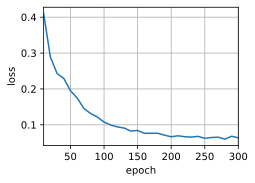

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va va ne va ne trouve trouve trouve trouve trouve, bleu 0.000
i lost . => j'ai je je tu tu tu tu tu tu tu, bleu 0.000
he's calm . => c'est comme comme comme comme comme comme comme comme comme, bleu 0.000
i'm home . => je je je je je je je je je je, bleu 0.000


### 练习 9.7.5

用长短期记忆网络替换门控循环单元重新运行实验。

**解答：**

In [ ]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [ ]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [ ]:
state[0].shape

torch.Size([2, 4, 16])

In [ ]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        state = enc_outputs[1]
        return state

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1][0].unsqueeze(0).repeat(X.shape[0], 1, 1)    # 在LSTM中，相较于隐藏状态，记忆元中存储了更多信息，有利于捕捉长期依赖关系，因此这里提取记忆元而非隐藏状态
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [ ]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))

output, state = decoder(X, state)
output.shape, state[0].shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

loss 0.018, 19088.3 tokens/sec on cuda:0


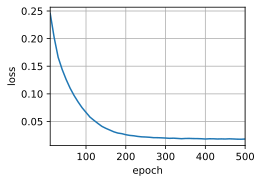

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 500, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est calme ., bleu 1.000
i'm home . => je suis chez moi ., bleu 1.000


### 练习 9.7.6

有没有其他方法来设计解码器的输出层？

**解答：**

&emsp;&emsp;可以在解码器的输出层应用注意力机制，通过计算注意力权重来对编码器的隐藏状态进行加权求和，从而生成输出。在类似机器翻译任务中，这种方法可以将解码器的注意力集中在输入序列的相关部分，有效捕捉重要信息。提高生成的准确性。

## 9.8 束搜索 

### 练习 9.8.1

我们可以把穷举搜索看作一种特殊的束搜索吗？为什么？

**解答：**

&emsp;&emsp;穷举与束搜索采用了不同的思路，并不能将其看作是特殊的束搜索。  
&emsp;&emsp;在进行穷举时，算法会对解空间中的所有解进行遍历搜索，然后计算出最优结果。因此导致计算量巨大。但是束搜索则是根据设置好的束宽$K$来进行搜索，在每一步选择$K$个最优结果，在保证找到最优解的前提下，尽量减少空间与时间复杂度。实际上，贪心和束搜索都属于启发式算法的一种，而穷举搜索并不包含任何启发式信息，因此不能看作是特殊的束搜搜。

### 练习 9.8.2

在9.7节中的机器翻译问题中应用束搜索。束宽是如何影响预测的速度和结果的？

**解答：**

&emsp;&emsp;在机器翻译任务中，虽然应用束搜索可以有效提高预测的准确性，生成更加合理的翻译结果。但是束搜索也会通过束宽来影响模型的预测速度和结果。  
&emsp;&emsp;作为控制候选项数量的参数，束宽较小时会减少搜索空间，带来更快的预测速度。而在较大时会保留更多的候选项，虽然可以带来更加准确的结果，但是也会增加计算的复杂性和预测时间。因此在设置束宽时需要权衡预测速度和结果精度，根据实际需求和性能进行调整，以取得满意的翻译结果。

### 练习 9.8.3

在8.5节中，我们基于用户提供的前缀，通过使用语言模型来生成文本。这个例子中使用了哪种搜索策略？可以改进吗？

**解答：**

&emsp;&emsp;在8.5节中，最后在生成文本时，在每一步预测中，使用 **y.argmax(dim=1)** 选择具有最高概率的字符作为下一个预测字符。这里的选择是基于当前时刻模型的输出概率最大化的策略，而没有考虑其他备选字符,这种搜索算法实质上属于贪心算法。  
&emsp;&emsp;可以通过修改策略来生成更具多样性的文本，例如通过束搜索的方式，在每一步选择多个候选字符，并根据概率得分进行排序。最终只保留得分最高的一部分候选字符，然后基于这些候选字符继续生成下一个字符。这种束搜索算法可以提供更好的生成文本质量和连贯性，但会增加计算复杂度。